# Street View Image Metadata

The Street View API metadata requests provide data about Street View panoramas. Using the metadata, you can find out if a Street View image is available at a given location.

Street View API metadata requests are free to use. **No quota is consumed** when you request metadata. Quota is only consumed when you load an image using the Street View API.

In [53]:
import os
import json
import overpass
import pandas as pd
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen, HTTPError
from gsvloader import polygon_to_points, loader

keys = pd.read_csv('api-keys.csv', header=None)

## Check Geojson properties

In [54]:
with open(os.path.join('data','shapefiles','นครศรีธรรมราช.geojson')) as f:
    data = json.load(f)
data['features'][0]['properties']

{'AP_EN': None,
 'AP_IDN': '8002',
 'AP_TN': 'พรหมคีรี',
 'PV_EN': None,
 'PV_IDN': '80',
 'PV_TN': 'นครศรีธรรมราช',
 'TB_EN': 'Thon Hong',
 'TB_IDN': '800204',
 'TB_TN': 'ทอนหงส์'}

## Sample Subdistrict

In [55]:
geojson_prop = {
    'PV_TN': 'นครศรีธรรมราช',
    'AP_TN': 'พรหมคีรี',
    'TB_TN': 'ทอนหงส์'
}

entry = {
    'GEOJSON_PATH': os.path.join('data','shapefiles','นครศรีธรรมราช.geojson'),
    'keys': np.squeeze(keys.values)
}

### Get polygon of the area

['ทอนหงส์', 'นครศรีธรรมราช', 'พรหมคีรี']


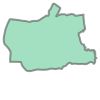

In [25]:
polygon = polygon_to_points.get_polygon(entry, geojson_prop)
polygon

### Extract coordinates along roads/streets

In [26]:
points = polygon_to_points.extract_coordinates(polygon)

converting linestrings to coordinates: 100%|██████████| 97/97 [00:07<00:00, 12.98it/s]


### Dump extracted roads coordinates to file
* http://geojson.io

In [59]:
def dump_to_file(points, filename):
    geojson = {
        "features": [],
        "type": "FeatureCollection"
    }

    for point in points:
        lat, lng = point
        geojson['features'].append({
            "type": "Feature",
            "geometry": {
            "type": "Point",
                "coordinates": [lng, lat]
            },
            "properties": {}
        })

    with open(os.path.join('data', filename), 'w') as FILE:
        json.dump(geojson, FILE)

In [60]:
dump_to_file(points, 'original.geojson')

### Send requests if a Street View image is available at a given location.

In [57]:
missing_streets = []
for lat, lng in tqdm(points, 'loading GSV'):
    requestMeta = urlopen(
        "https://maps.googleapis.com/maps/api/streetview/metadata?"+\
        "location="+str(lat)+','+str(lng)+"&key="+entry['keys'][0]
    )    
    metaJson = json.loads(requestMeta.read().decode('utf8'))
    if metaJson["status"] != 'OK':
        missing_streets.append([lat, lng])

loading GSV: 100%|██████████| 1414/1414 [07:43<00:00,  3.05it/s]


In [61]:
dump_to_file(missing_streets, 'missing.geojson')

### Example of metadata
* street view available
```json
{'copyright': '© Google, Inc.',
 'date': '2016-06',
 'location': {'lat': 8.601592312833652, 'lng': 99.80298133747272},
 'pano_id': 'u5Hn4GeNtMtk1EvLOa-N5w',
 'status': 'OK'}
```
* street view unavailable
```json
{'status': 'ZERO_RESULTS'}
```

Ref: https://developers.google.com/maps/documentation/streetview/metadata